# Exercises day 02

In [74]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

NUMS_TO_GENERATE = 10 ** 4

## Ex01

**Choose a value for the probability parameter $p$ in the geometric distribution and simulate $10,000$ outcomes. You can experiment with a small, moderate and large value if you like.**

Max of geometric dist: 9


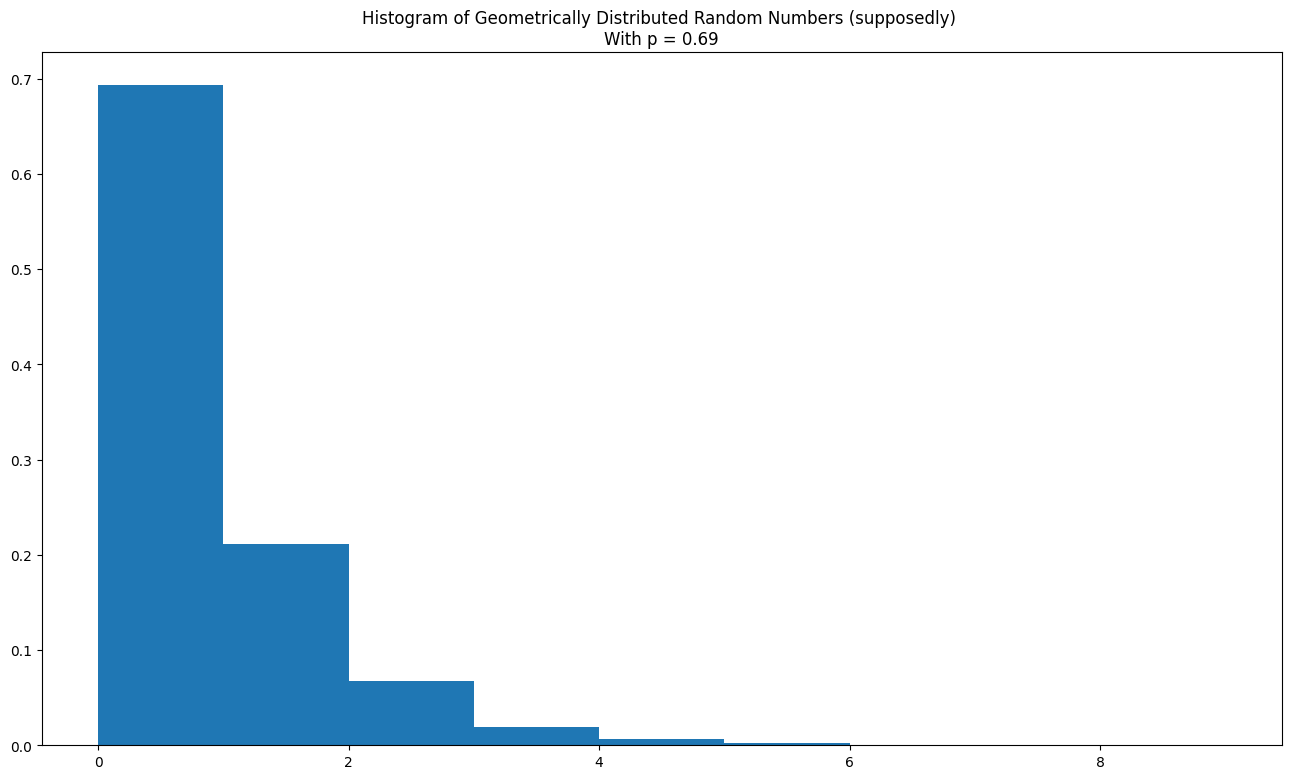

In [31]:
# We have been told that we can use a library to generate random numbers
# Tobias says that we should pick a fixed p in the the open interval (0,1)
p = 0.69

NUMS_TO_GENERATE = 10 ** 4

uniform_nums = np.random.uniform(0.0, 1.0, NUMS_TO_GENERATE)
geometric_nums = np.floor(np.log(uniform_nums) / np.log(1 - p))

max_geometric = int(max(geometric_nums))
print(f"Max of geometric dist: {max_geometric}")

plt.figure(figsize=(16, 9))
plt.title(f"Histogram of Geometrically Distributed Random Numbers (supposedly) \nWith p = {p}")
plt.hist(geometric_nums, bins=range(max_geometric + 1), density=True)
plt.show()


### Experiments with different values of p

Max of geometric dist_0: 140
Max of geometric dist_1: 87
Max of geometric dist_2: 35
Max of geometric dist_3: 18
Max of geometric dist_4: 8
Max of geometric dist_5: 6
Max of geometric dist_6: 4
Max of geometric dist_7: 3
Max of geometric dist_8: 1


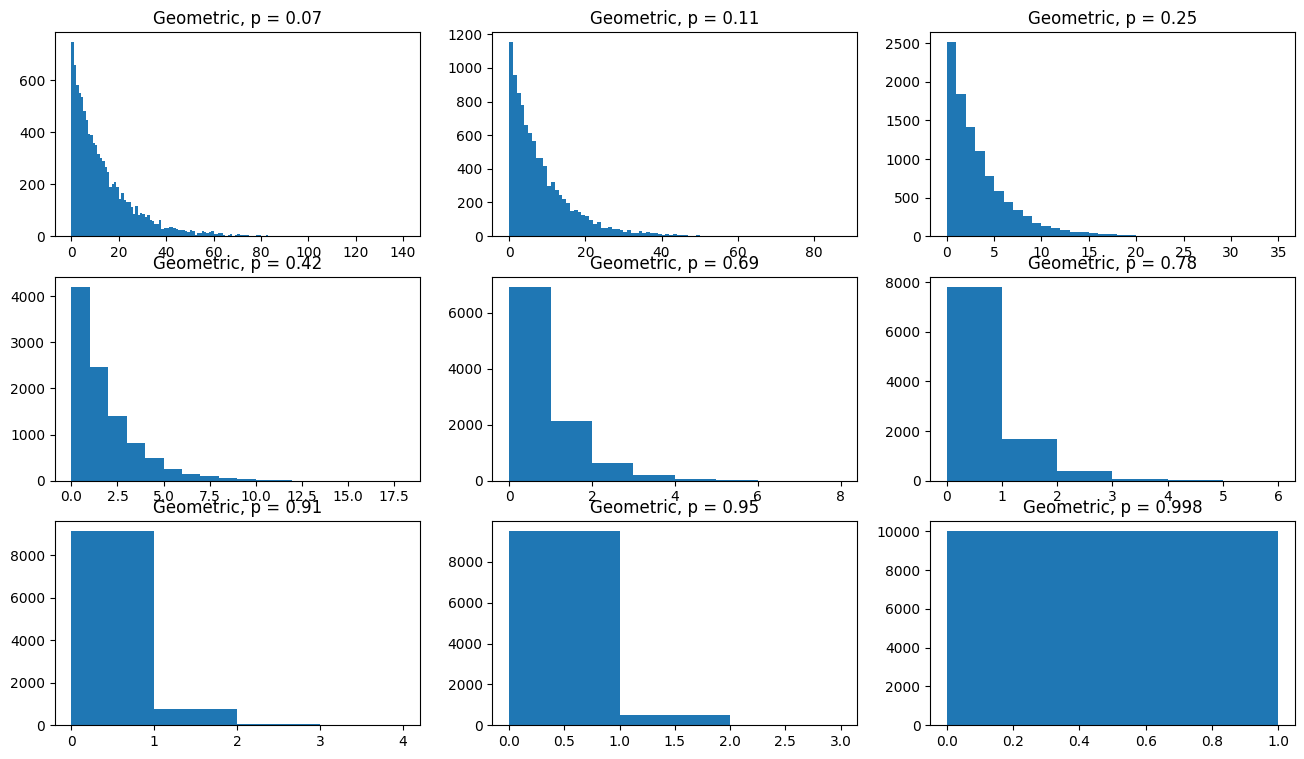

In [32]:
experimental_ps = [0.07, 0.11, 0.25, 0.42, 0.69, 0.78, 0.91, 0.95, 0.998]
uniform_nums = np.random.uniform(0.0, 1.0, NUMS_TO_GENERATE)

plt.figure(figsize=(16, 9))
for i in range(len(experimental_ps)):
    plt.subplot(3, 3, i + 1)
    geometric_nums = np.floor(np.log(uniform_nums) / np.log(1 - experimental_ps[i]))
    max_geometric = int(max(geometric_nums))
    print(f"Max of geometric dist_{i}: {max_geometric}")
    
    plt.title(f"Geometric, p = {experimental_ps[i]}")
    plt.hist(geometric_nums, bins=range(max_geometric + 1))

plt.show()

The geometric number generator works as expected for different values of $p$. 

## Ex02
**The distribution should look something like:**

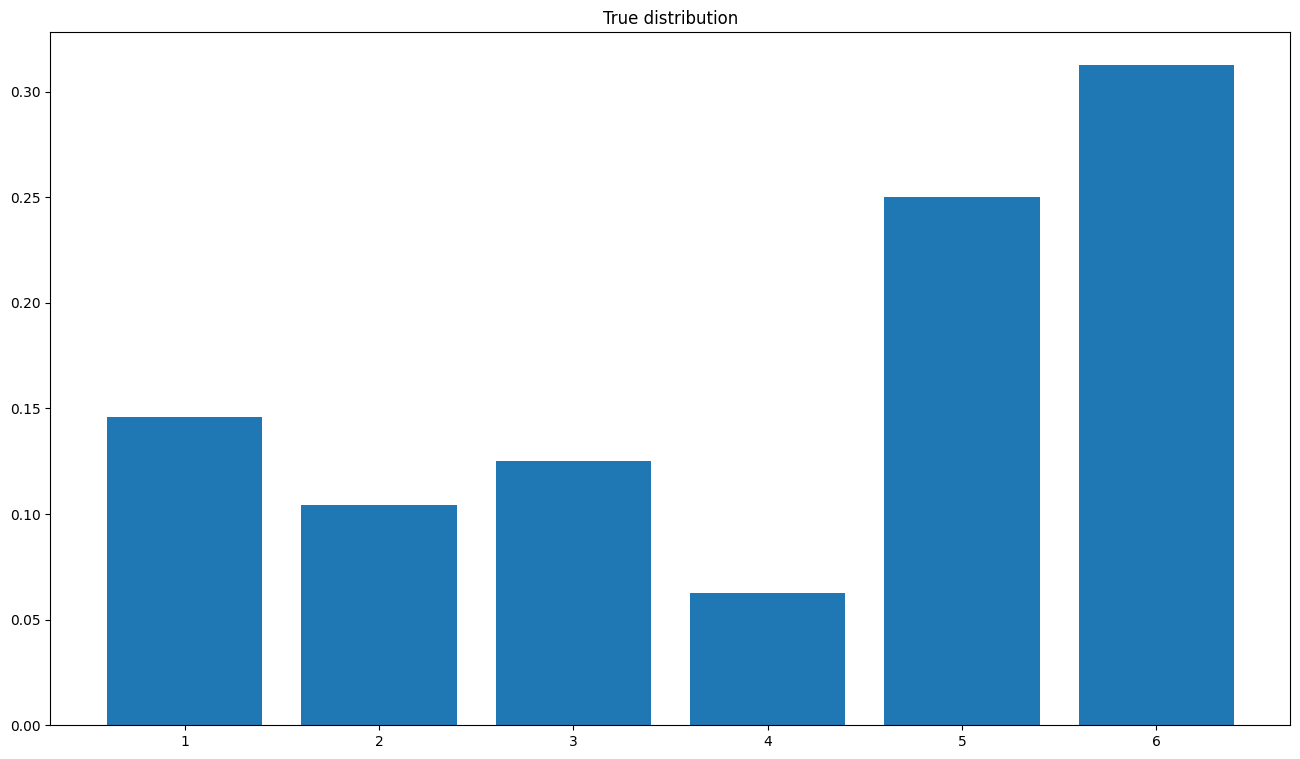

In [33]:
six_points = [7 / 48, 5 / 48, 1 / 8, 1 / 16, 1 / 4, 5 / 16] # Probs for each class. 
k = len(six_points)

plt.figure(figsize=(16, 9))
plt.title('True distribution')
plt.bar(range(1,7),six_points)
plt.show()

### a) direct (crude) method

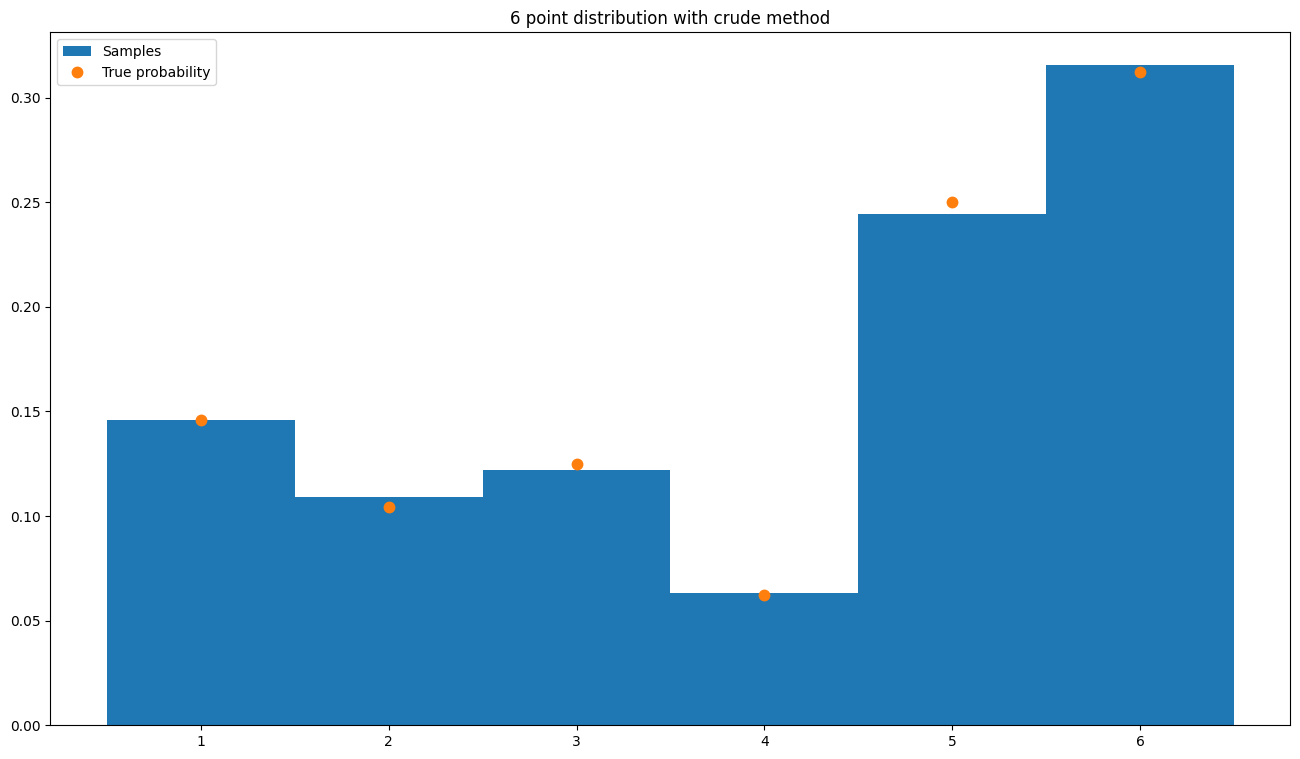

In [54]:


def geometric_crude(num_samples: int=NUMS_TO_GENERATE):
    # Generate uniform samples
    U = np.random.uniform(0.0, 1.0, num_samples)
    X = np.zeros(num_samples, dtype=np.int16)

    for i in range(len(six_points)):
        #print(f"iter {i}: left {six_points[:i]} \tright {six_points[:(i+1)]}")
        p_bool = ((np.sum(six_points[:i]) < U) & (U <= np.sum(six_points[:(i+1)])))
        X[p_bool] = i + 1
    return X
    
X = geometric_crude()

bins = np.arange(1, k + 1.5) - 0.5
plt.figure(figsize=(16, 9))
plt.title(f"6 point distribution with crude method")
plt.hist(X, bins=bins, density=True, label='Samples')
plt.plot(np.arange(1,7),six_points,'.', markersize=15, label='True probability')
plt.legend()
plt.show()

### b) by using the the rejction method

This is a very naive way to do it

In [36]:
def geometric_reject(num_samples : int = NUMS_TO_GENERATE):
    # Initially we just pick c to be equal to max(p_i) for i in range(k).
    c = max(six_points)

    k = len(six_points)

    accepts = []
    count = 0
    while count < num_samples:
        I = int(k * np.random.uniform(0.0, 1.0)) + 1 # <-- int always floors
        if np.random.uniform(0.0, 1.0) <= six_points[(I - 1)] / c:
            accepts.append(I)
            count += 1
    return accepts

accepts = geometric_reject()


**Plotting it:**


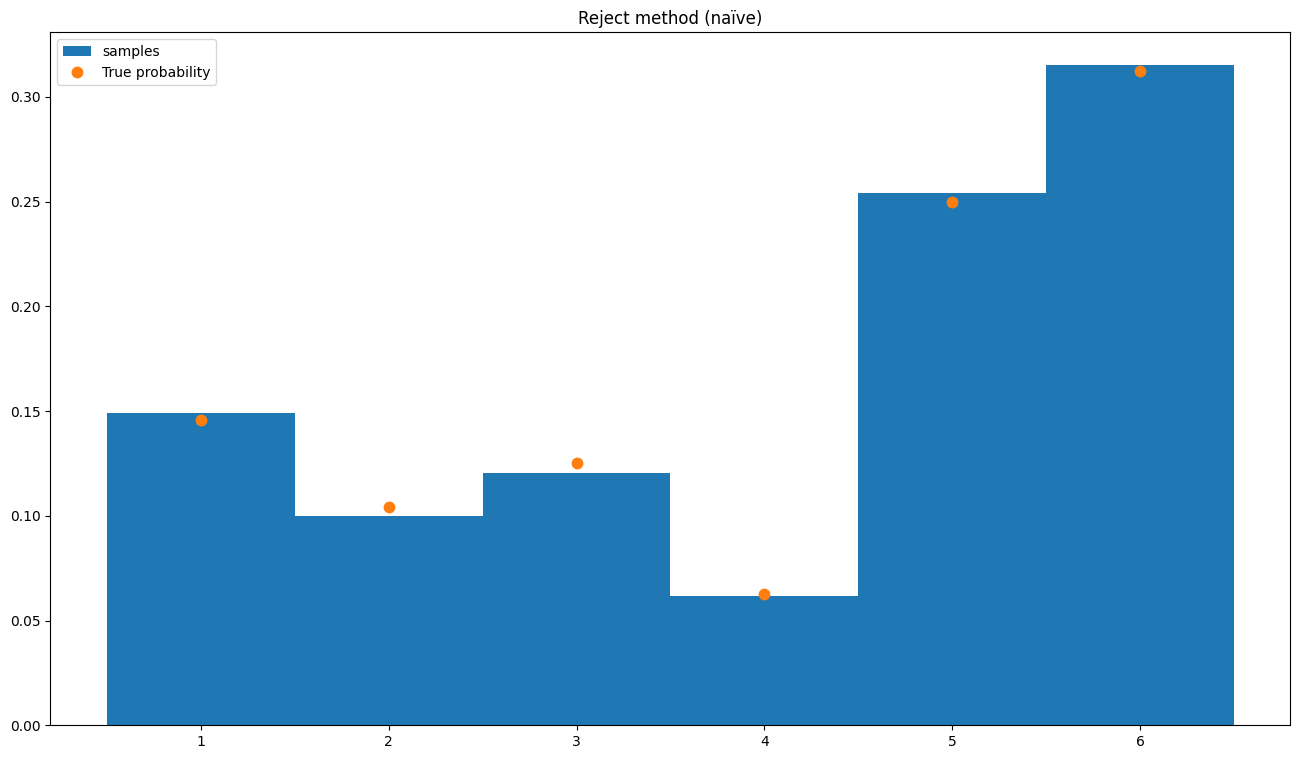

In [37]:
plt.figure(figsize=(16, 9))
plt.title(f"Reject method (naïve)")
plt.hist(accepts, bins=bins, density=True, label='samples')
plt.plot(np.arange(1,7),six_points,'.', markersize=15, label='True probability')
plt.legend()
plt.show()

### c) by using the Alias method


In [38]:
def generate_F_L_table(probabilities : list[float]) -> tuple[list[float], list[int]]:
    """
        For the Alias method, the alias tables must be generated. These are generated here
        as per pseudo-code given on slides from the second lecture.
        (See slide 16 on 'slide3m1.pdf')
        
        :param probabilities: A list of probabilities for each of the k points
        
        :return: A tuple containing the alias tables F and L (both as lists)
    """
    
    # For some reason we have a machine epsilon in this algorithm:
    MACHINE_EPSILON = np.finfo(np.float64).eps

    # Bo said to initialize L to itself:
    k = len(probabilities)
    L = list(range(k))
    F = np.array([k * p for p in probabilities])

    # np.where returns a tuple, but our is one-dimensional, hence the indexing
    G = np.where(F >= 1)[0]
    S = np.where(F <= 1)[0]

    #print(f"S: {S}")
    #print(f"G: {G}")

    while S.size != 0:  # <-- Checking whether S is empty
        
        i = G[0]
        j = S[0]
        L[j] = i
        F[i] = F[i] - (1 - F[j])
        if F[i] < 1 - MACHINE_EPSILON:
            G = np.delete(G, 0) # <-- this is equivalent to popping on a numpy array, probably terribly slow
            S = np.append(S, i) # <-- numpy appending is wack-a-doodles
        S = np.delete(S, 0) # <-- again: popping but in 'numpy'
    
    F = list(F)
    return F, L

In [39]:

def geometric_alias(num_samples: int = NUMS_TO_GENERATE):
    F, L = generate_F_L_table(six_points)

    U_1 = np.random.uniform(0.0, 1.0, num_samples)
    U_2 = np.random.uniform(0.0, 1.0, num_samples)
    Is = []
    samples = []

    for i in range(num_samples):
        I = int(k * U_1[i]) + 1
        Is.append(I)
        if U_2[i] <= F[I-1]:
            samples.append(I)
        else:
            samples.append(L[I-1]+1)
    
    return samples

samples =  geometric_alias()


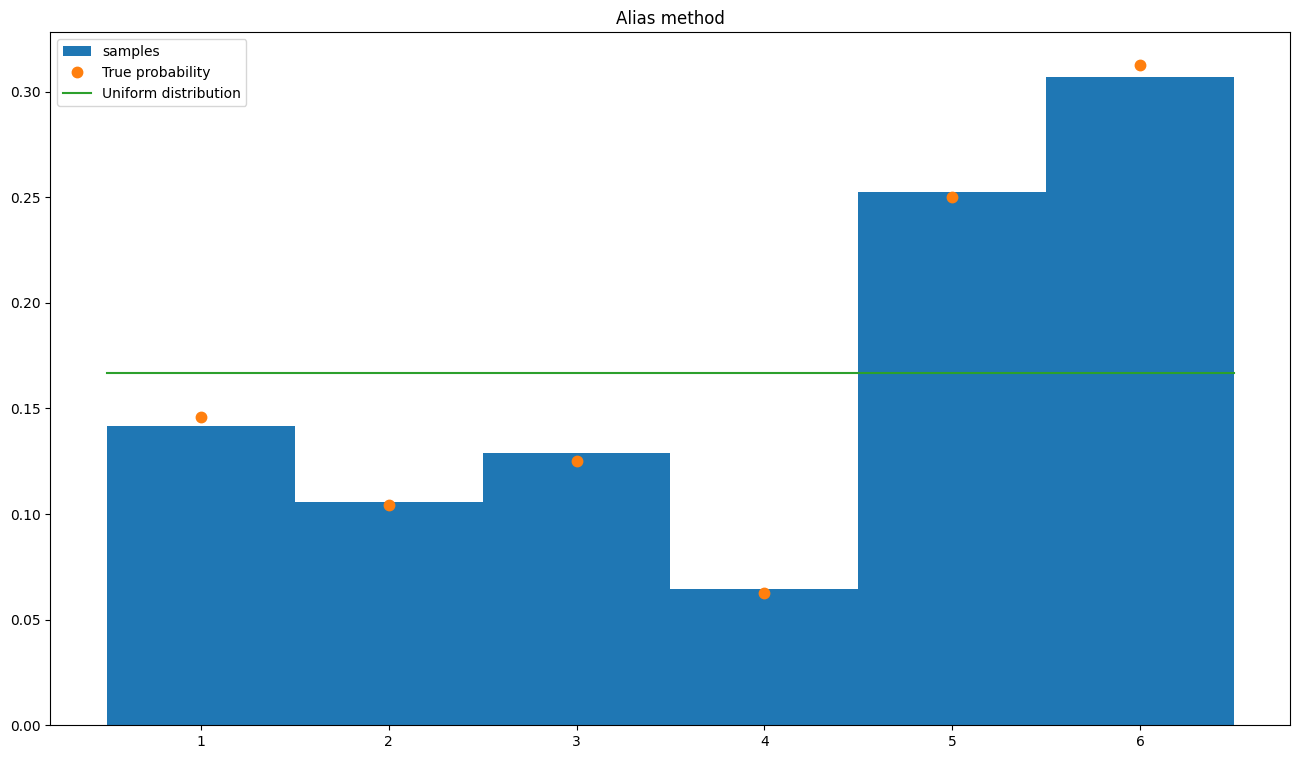

In [40]:
plt.figure(figsize=(16, 9))
plt.title(f"Alias method")
plt.hist(samples, bins=bins, density=True, label='samples')
plt.plot(np.arange(1,7),six_points,'.', markersize=15, label='True probability')
plt.plot(np.array([0,6])+0.5,[1/6]*2,label='Uniform distribution')
plt.legend()
plt.show()

## Ex03 

**Compare the three different methods using adequate criteria, then discuss the results.**

To aspects at the methods that could be interesting to compare is the comuterpower required and wether or not the samples do follow the geometric distribution with the given $p$.

In [96]:
samcples = geometric_crude(1)
test = chi_squared_test(samcples)
print(test)

0.9968807007061332


In [99]:
def chi_squared_test(samples : np.array, F_exp : np.array = six_points) -> float:
    """
        This function performs the chi-squared test on a list of random numbers, discrete distribution
      
    """
    
    N = len(samples)
    
    # Divied into bins
    num_bins = len(six_points)
    counts, _ = np.histogram(samples, bins=num_bins)
    F_obs = counts/N


    T = np.abs(np.sum((F_obs - F_exp)**2 / six_points))
    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p



In [120]:
num_samples_time = [10**i for i in range(5,10)]
num_samples_chitest = np.arange(2,1000)

chi_tests = []

for i in num_samples_chitest:
    crude_test = chi_squared_test(geometric_crude(i))
    reject_test = chi_squared_test(geometric_reject(i))
    alias_test = chi_squared_test(geometric_alias(i))
    chi_tests.append([crude_test,reject_test,alias_test])

chi_tests = np.array(chi_tests)

times = []                        
for i in num_samples_time:
    print(f"{i} samples")
    # crude
    start = time.time()
    geometric_crude(i)
    crude_time = round((time.time() - start)/60, 2)

    # Reject
    start = time.time()
    geometric_reject(i)
    reject_time = round((time.time() - start)/60, 2)

    # Alias
    start = time.time()
    geometric_alias(i)
    alis_time = round((time.time() - start)/60, 2)

    times.append([crude_time,reject_time,reject_time])

times = np.array(times)

print(times)

100000 samples
1000000 samples
10000000 samples
100000000 samples


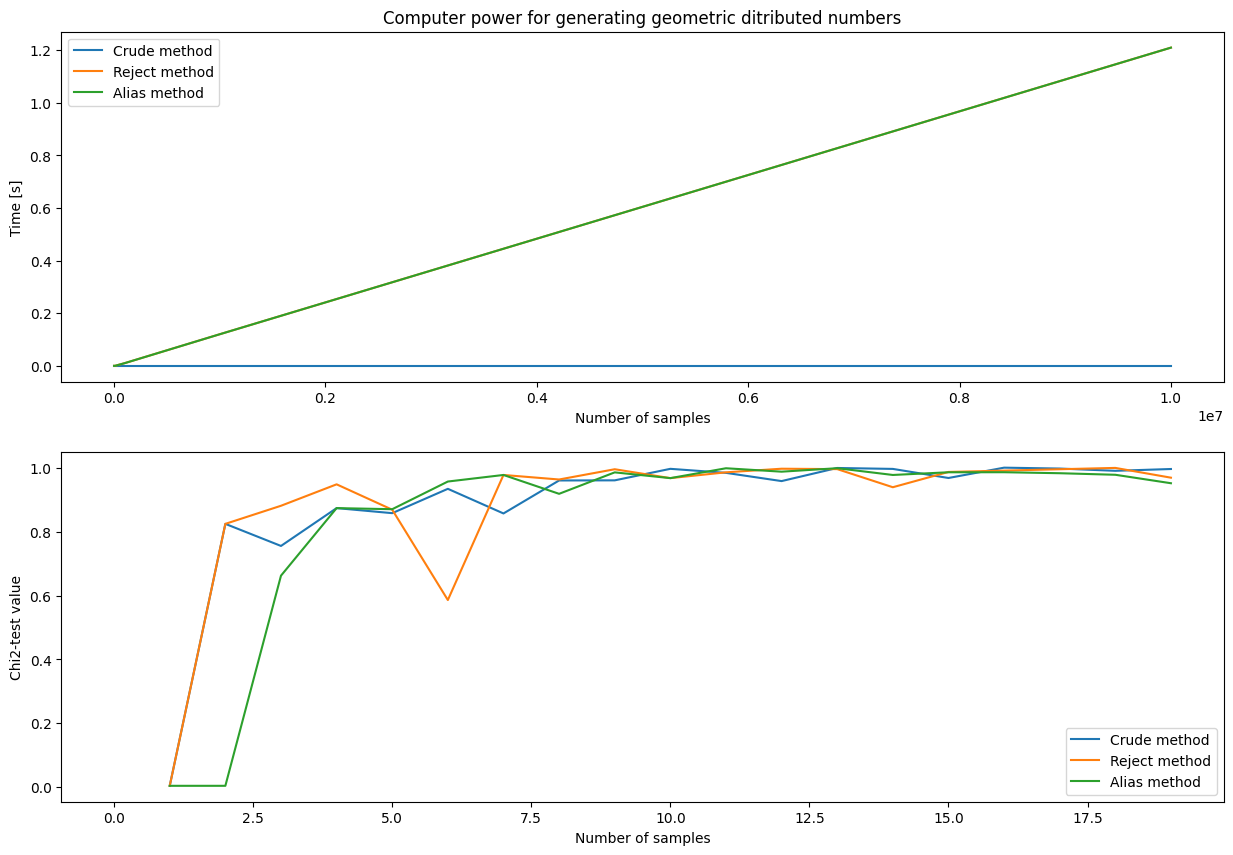

In [109]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Computer power for generating geometric ditributed numbers')
plt.plot(num_samples_time,times[:,0],label = 'Crude method')
plt.plot(num_samples_time,times[:,1],label = 'Reject method')
plt.plot(num_samples_time,times[:,2],label = 'Alias method')
plt.xlabel('Number of samples')
plt.ylabel('Time [s]')
plt.legend()

plt.subplot(2,1,2)
plt.plot(num_samples_chitest,chi_tests[:,0],label = 'Crude method')
plt.plot(num_samples_chitest,chi_tests[:,1],label = 'Reject method')
plt.plot(num_samples_chitest,chi_tests[:,2],label = 'Alias method')
plt.plot(0,1,c='black')
plt.xlabel('Number of samples')
plt.ylabel('Chi2-test value')
plt.legend()
plt.show()




## Ex04
In relation to whether the method actually samples from the desired geometric distribution, all the methods does not requires a lot of samples. Already with only 20 samples the $\chi^2$ test value is equite height, meaning they all perform well in the aspect.  

The crude method is a simple method, where you only sample uniformly once for the number of desired samples. 

The downside of the reject method is that is can be hard to contral the acceptance rate. Our method will keep sampling proposal samples until enought samples has been accepted. For this simple distribution, the acceptance ratio is expected to by high hence giving a high acceptance rate, but for more compicated there is no garentee that any samples will be accepted. The required computerpower might therefore be greater if you have to sample a lot of samples that will not be used in the end. 

The alias method required a lot of implementation compared to the other methods, and might not have been implemented the most effeciently. For this method you don't have the problem as rejection sampling with a low acceptance rate as all samples that is generated will be used. The method required two uniform sampled distributions meaning you must sample twice as many samples as the number you wish for. 